In [ ]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
100% 2.04G/2.04G [01:37<00:00, 24.4MB/s]
100% 2.04G/2.04G [01:37<00:00, 22.5MB/s]


In [ ]:
!unzip plantvillage-dataset.zip -d ./plantvillage

Streaming output truncated to the last 5000 lines.
  inflating: ./plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: ./plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: ./plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: ./plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: ./plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: ./plantvillage/plantvillage dataset/segmented/Tomato___Tomato_Yel

In [ ]:

import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import EfficientNetB3
from pathlib import Path
from tensorflow.keras.metrics import Precision, Recall
import shutil
import random


In [ ]:
dataset_dir = Path('/content/plantvillage/plantvillage dataset/color')
output_dir = Path('/content/splitimages')

for split in ['train', 'test', 'val']:
    for class_dir in dataset_dir.iterdir():
        if class_dir.is_dir():
            (output_dir / split / class_dir.name).mkdir(parents=True, exist_ok=True)

for class_dir in dataset_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.iterdir())
        random.shuffle(images)

        train_split = int(0.8 * len(images))
        test_split = int(0.9 * len(images))

        train_images = images[:train_split]
        test_images = images[train_split:test_split]
        val_images = images[test_split:]

        for image in train_images:
            shutil.copy(image, output_dir / 'train' / class_dir.name / image.name)
        for image in test_images:
            shutil.copy(image, output_dir / 'test' / class_dir.name / image.name)
        for image in val_images:
            shutil.copy(image, output_dir / 'val' / class_dir.name / image.name)

print("Dataset successfully split into train, test, and val sets.")


Dataset successfully split into train, test, and val sets.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=70,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=(0.7, 1.3),
    horizontal_flip=True,
    brightness_range=(0.6, 1.4),
    fill_mode='nearest'
)

train_data = train_datagen.flow_from_directory(
    '/content/splitimages/train',
    target_size=(299, 299),
    batch_size=16,
    class_mode='categorical'
)


val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/splitimages/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(299, 299),
    batch_size=16
).map(lambda x, y: (x / 255.0, y))

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/splitimages/test',
    labels='inferred',
    label_mode='categorical',
    image_size=(299, 299),
    batch_size=16
)

class_names = test_data.class_names


Found 43429 images belonging to 38 classes.
Found 5448 files belonging to 38 classes.
Found 5428 files belonging to 38 classes.


In [ ]:
import os
import random
from pathlib import Path
from collections import Counter
from shutil import copy2

# Path to the train directory where images are stored by class
train_dir = Path('/content/splitimages/train')

# Count images per class
class_counts = {class_dir.name: len(list(class_dir.iterdir())) for class_dir in train_dir.iterdir() if class_dir.is_dir()}
max_count = max(class_counts.values())

print("Class distribution before oversampling:", class_counts)

# Oversample by duplicating images in each class until they match the max_count
for class_name, count in class_counts.items():
    class_dir = train_dir / class_name
    if count < max_count:
        images = list(class_dir.iterdir())
        while len(images) < max_count:
            # Select a random image to duplicate
            image_to_duplicate = random.choice(images)
            new_image_name = f"{image_to_duplicate.stem}_dup{len(images)}{image_to_duplicate.suffix}"
            new_image_path = class_dir / new_image_name
            copy2(image_to_duplicate, new_image_path)
            images.append(new_image_path)

# Verify the new distribution
new_class_counts = {class_dir.name: len(list(class_dir.iterdir())) for class_dir in train_dir.iterdir() if class_dir.is_dir()}
print("Class distribution after oversampling:", new_class_counts)


Class distribution before oversampling: {'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 4285, 'Tomato___Tomato_mosaic_virus': 298, 'Cherry_(including_sour)___Powdery_mildew': 841, 'Potato___Early_blight': 800, 'Tomato___Leaf_Mold': 761, 'Tomato___Late_blight': 1527, 'Peach___Bacterial_spot': 1837, 'Tomato___Target_Spot': 1123, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 860, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 410, 'Tomato___Bacterial_spot': 1701, 'Tomato___healthy': 1272, 'Grape___healthy': 338, 'Raspberry___healthy': 296, 'Peach___healthy': 288, 'Tomato___Spider_mites Two-spotted_spider_mite': 1340, 'Corn_(maize)___Common_rust_': 953, 'Apple___Cedar_apple_rust': 220, 'Corn_(maize)___Northern_Leaf_Blight': 788, 'Grape___Black_rot': 944, 'Apple___healthy': 1316, 'Potato___Late_blight': 800, 'Apple___Apple_scab': 504, 'Pepper,_bell___Bacterial_spot': 797, 'Apple___Black_rot': 496, 'Soybean___healthy': 4072, 'Strawberry___healthy': 364, 'Squash___Powdery_mildew': 1468, 'Ch

In [ ]:
from tensorflow.keras.applications import EfficientNetB3

# Load the pre-trained EfficientNetB3 model
conv_base = EfficientNetB3(
    weights='imagenet',
    include_top=False,
    input_shape=(299, 299, 3)
)

conv_base.trainable = True




In [ ]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(38, activation='softmax', kernel_regularizer=l2(0.005))
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name="precision"), Recall(name="recall")])


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 10, 10, 1536)        │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,216,341 (42.79 MB)

 Trainable params: 11,128,270 (42.45 MB)

 Non-trainable params: 88,071 (344.03 KB)

In [24]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[early_stopping]
)


Epoch 1/25
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 1161s 383ms/step - accuracy: 0.4408 - loss: 5.5604 - precision: 0.7351 - recall: 0.3125 - val_accuracy: 0.9688 - val_loss: 2.6920 - val_precision: 0.9790 - val_recall: 0.9565
Epoch 2/25
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 951s 349ms/step - accuracy: 0.9019 - loss: 2.7269 - precision: 0.9523 - recall: 0.8377 - val_accuracy: 0.9864 - val_loss: 1.5811 - val_precision: 0.9895 - val_recall: 0.9818
Epoch 3/25
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 948s 348ms/step - accuracy: 0.9468 - loss: 1.5554 - precision: 0.9703 - recall: 0.9198 - val_accuracy: 0.9912 - val_loss: 0.8563 - val_precision: 0.9923 - val_recall: 0.9901
Epoch 4/25
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 954s 350ms/step - accuracy: 0.9642 - loss: 0.8716 - precision: 0.9774 - recall: 0.9471 - val_accuracy: 0.9910 - val_loss: 0.5000 - val_precision: 0.9914 - val_recall: 0.9905
Epoch 5/25
2715/2715 ━━━━━━━━━━━━━━━━━━━━ 953s 350ms/step - accuracy: 0.9732 - loss: 0.5472 - precision: 0.9824 - recall: 0.9622 - val_

In [25]:
test_data = test_data.map(lambda x, y: (x / 255.0, y))

print("Class Names:", class_names)

Class Names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomat

In [26]:
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

y_true = []
y_pred = []

for images, labels in test_data:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(images), axis=1))

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

report_df = pd.DataFrame(report).transpose()

report_df = report_df[['precision', 'recall', 'f1-score', 'support']].round(2)

print(report_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━

In [27]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")



340/340 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - accuracy: 0.9970 - loss: 0.0789 - precision: 0.9972 - recall: 0.9970
Test Accuracy: 1.00
Test Precision: 1.00
Test Recall: 1.00


In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Iterate over batches of test data and display predictions and actual labels
def predict_and_display_batch(model, test_data, class_names, batch_size=16):
    for images, labels in test_data.take(1):  # Take a single batch
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        true_classes = np.argmax(labels.numpy(), axis=1)

        plt.figure(figsize=(15, batch_size))
        for i in range(min(batch_size, len(images))):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Pred: {class_names[predicted_classes[i]]}\nTrue: {class_names[true_classes[i]]}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()

In [35]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array


def upload_and_predict(model, image_path, class_names, target_size=(299, 299)):

    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    plt.imshow(img)
    plt.title(f"Predicted: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()


In [38]:
from sklearn.metrics import classification_report
import numpy as np


y_true = []
y_pred = []

for images, labels in test_data:

    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(images), axis=1))


report = classification_report(y_true, y_pred, output_dict=True)


print(f"{'Class':<10} {'Accuracy':<15} {'Recall':<15} {'Precision':<15}")
print("-" * 55)


for label, metrics in report.items():
    if label.isdigit():
        print(f"{'Class ' + label:<10} "
              f"{metrics['f1-score']:<15.2f} "
              f"{metrics['recall']:<15.2f} "
              f"{metrics['precision']:<15.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

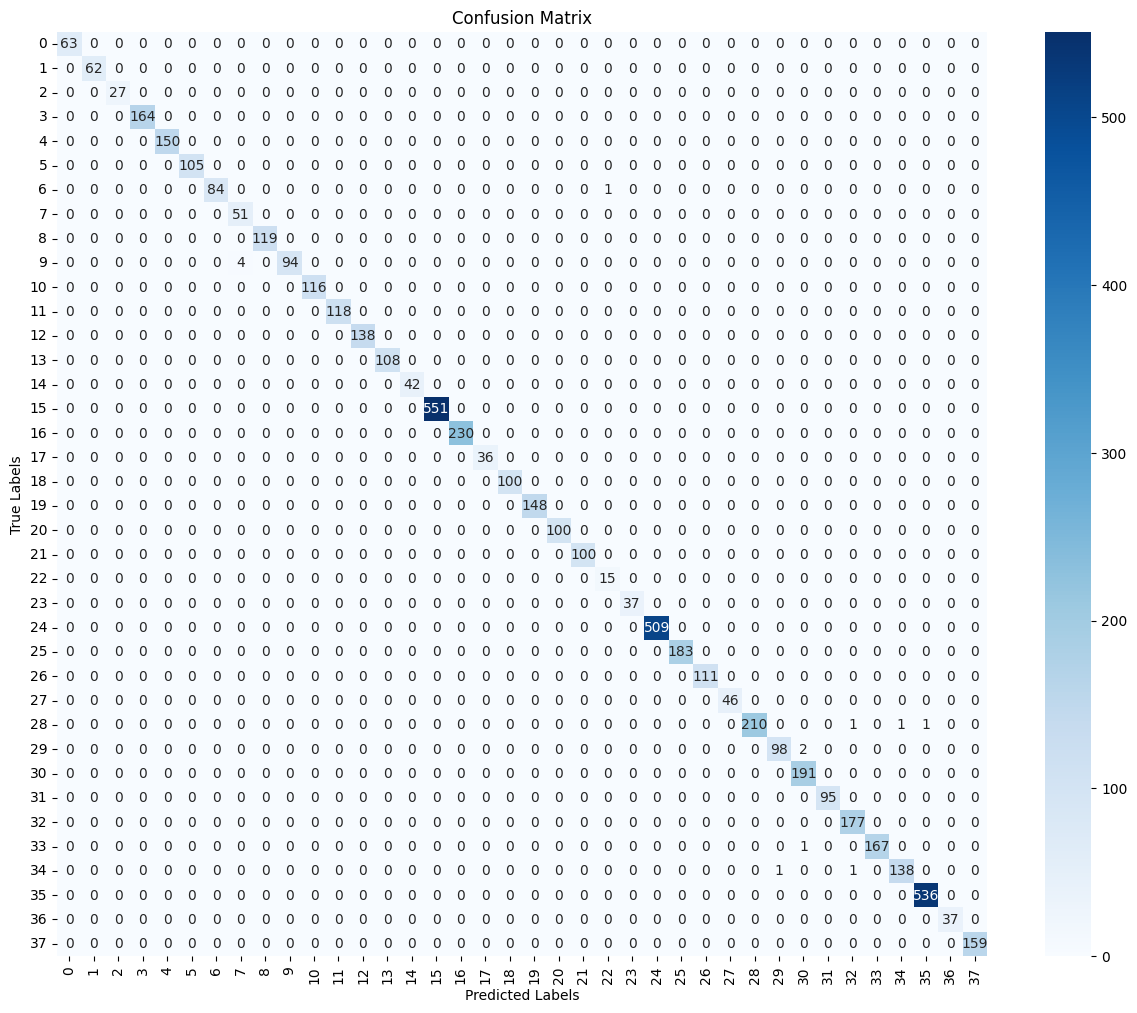

In [39]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


y_true = []
y_pred = []

for images, labels in test_data:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(images), axis=1))


conf_matrix = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(15, 12))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.arange(conf_matrix.shape[1]),
            yticklabels=np.arange(conf_matrix.shape[0]), cbar=True)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()



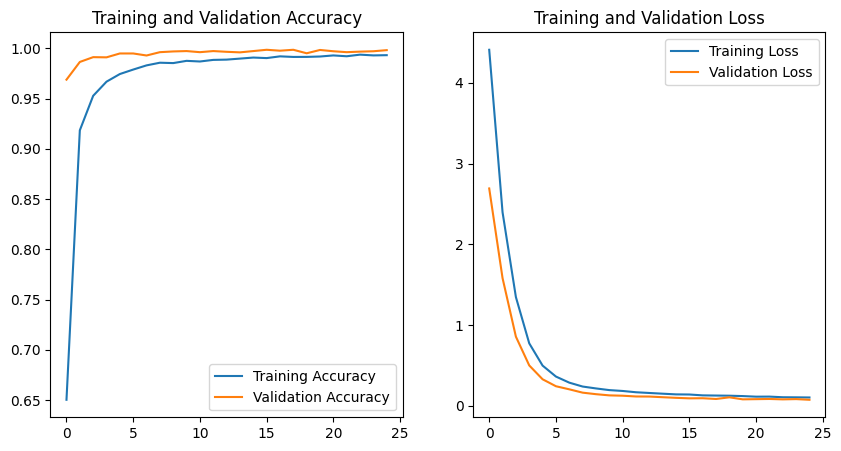

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


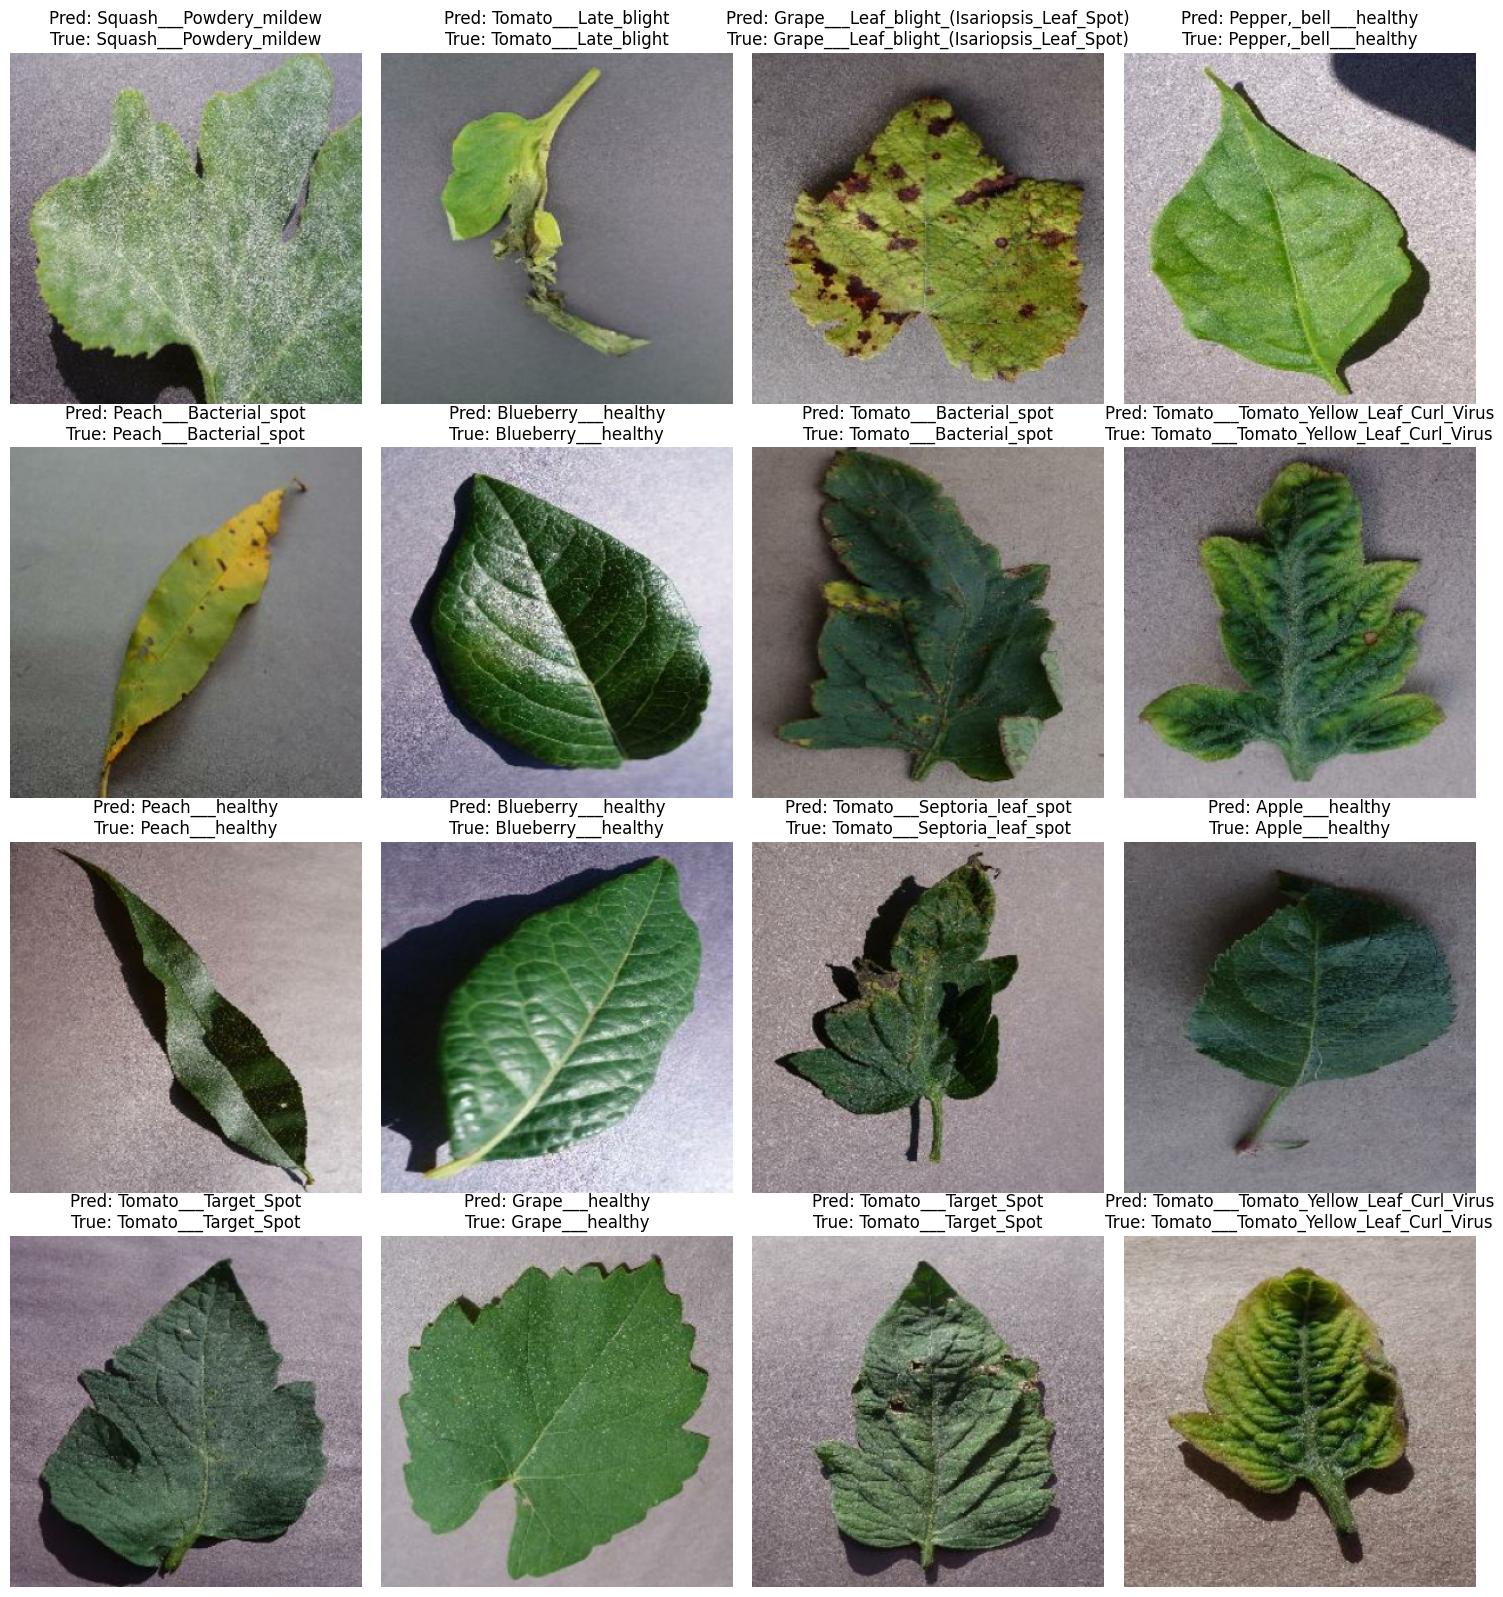

In [36]:
predict_and_display_batch(model, test_data, class_names, batch_size=16)


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


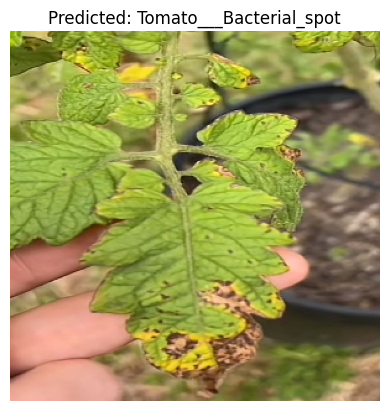

In [37]:

image_path = "/content/WhatsApp Image 2024-11-29 at 7.15.11 PM.jpeg"
upload_and_predict(model, image_path, class_names)


In [41]:
# Correct file name with .weights.h5 extension
weights_save_path = 'plantvillage.weights.h5'

# Save the model weights
model.save_weights(weights_save_path)

print(f"Model weights saved to: {weights_save_path}")

Model weights saved to: plantvillage.weights.h5
